In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import skew
# For Progress Bar
from tqdm import tqdm
from datetime import datetime
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

from sklearn.linear_model import LinearRegression

In [3]:
train_data,valid_data,test_data=pd.read_csv('/content/drive/MyDrive/machine_learning/HW1/train-v3.csv'),pd.read_csv('/content/drive/MyDrive/machine_learning/HW1/valid-v3.csv'),pd.read_csv('/content/drive/MyDrive/machine_learning/HW1/test-v3.csv')
train_data=pd.concat([train_data,valid_data], axis=0,ignore_index=True) # 把index標籤弄掉
target=train_data['price'].copy()
# train_data[train_data.duplicated()]  # clear duplicate data
train_data.drop(labels='id',axis=1,inplace=True)
test_data.drop(labels='id',axis=1,inplace=True)


In [4]:
train_data.head()

,price,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,200000,2015,3,27,4,2.0,1900,8160,1,0,...,7,1900,0,1975,0,98022,47.2114,-121.986,1280,6532
1,350000,2014,9,2,4,3.0,3380,16133,1,0,...,8,2330,1050,1959,0,98118,47.5501,-122.261,2500,11100
2,254000,2014,12,11,3,2.0,2070,9000,1,0,...,7,1450,620,1969,0,98023,47.3085,-122.376,1630,7885
3,175000,2015,4,30,3,1.0,1150,8924,1,0,...,6,1150,0,1943,0,98030,47.3865,-122.217,1492,8924
4,619000,2015,3,31,3,2.5,2040,7503,2,0,...,8,2040,0,1987,0,98029,47.5718,-122.021,2170,7503


In [5]:
test_data.head()

,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2015,3,25,4,1.75,2360,6000,1,0,0,...,7,1280,1080,1955,0,98109,47.6465,-122.357,1700,3460
1,2015,5,1,3,2.75,3510,92347,2,0,0,...,10,3510,0,1990,0,98038,47.3735,-122.018,2970,37070
2,2014,8,29,2,1.00,1020,5000,1,0,0,...,7,1020,0,1916,0,98117,47.6781,-122.363,1480,5000
3,2015,2,13,2,2.50,1410,1281,2,0,0,...,8,1090,320,2008,0,98126,47.5659,-122.370,1410,2550
4,2014,11,19,3,2.50,2010,6857,1,0,0,...,9,1450,560,1955,0,98102,47.6402,-122.314,2380,6370


In [6]:
print('UNIQUE VALUES\n')
for col in train_data.columns:
    print(f'{col}: {len(train_data[col].unique())}\n')

UNIQUE VALUES

price: 3280

sale_yr: 2

sale_month: 12

sale_day: 31

bedrooms: 13

bathrooms: 29

sqft_living: 872

sqft_lot: 7677

floors: 3

waterfront: 2

view: 5

condition: 5

grade: 12

sqft_above: 793

sqft_basement: 272

yr_built: 116

yr_renovated: 68

zipcode: 70

lat: 4715

long: 713

sqft_living15: 670

sqft_lot15: 6911



In [7]:
train_data.columns

Index(['price', 'sale_yr', 'sale_month', 'sale_day', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# 資料前處理
### 1. 建造年份跟銷售出去的年份做相減 - 看 correlation < 0.1 (X)

In [8]:
# 沒用 因為時間越久長假越高
# 但是 沒辦法從 date_gap看出來說在第幾年賣掉的

"""
date_gap=[]
for i in range(len(train_data)):
  start_date=train_data.loc[i,'sale_yr']
  end_date = train_data.loc[i,'yr_built']
  date_gap.append(start_date-end_date)
train_data['data_gap']=date_gap
"""

"\ndate_gap=[]\nfor i in range(len(train_data)):\n  start_date=train_data.loc[i,'sale_yr']\n  end_date = train_data.loc[i,'yr_built']\n  date_gap.append(start_date-end_date)\ntrain_data['data_gap']=date_gap\n"

## 2.把裝修過的年份換成建造年份試試看

## prev-corrlation
### price-yr_renovated = 0.059
### price-yr_built   = 0.13

## After
#### price-yr_renovated = 0.059->0.11

In [9]:
start_year=[]
for i in range(len(train_data)):
  if train_data.loc[i,'yr_renovated'] != 0:
    start_year.append(train_data.loc[i,'yr_renovated'])
  else:
    start_year.append(train_data.loc[i,'yr_built'])
train_data['yr_built']=start_year

# train drop -> test drop
train_data.drop(labels=['yr_renovated'],axis=1,inplace=True)
test_data.drop(labels=['yr_renovated'],axis=1,inplace=True)
#

## Find Data Correlation

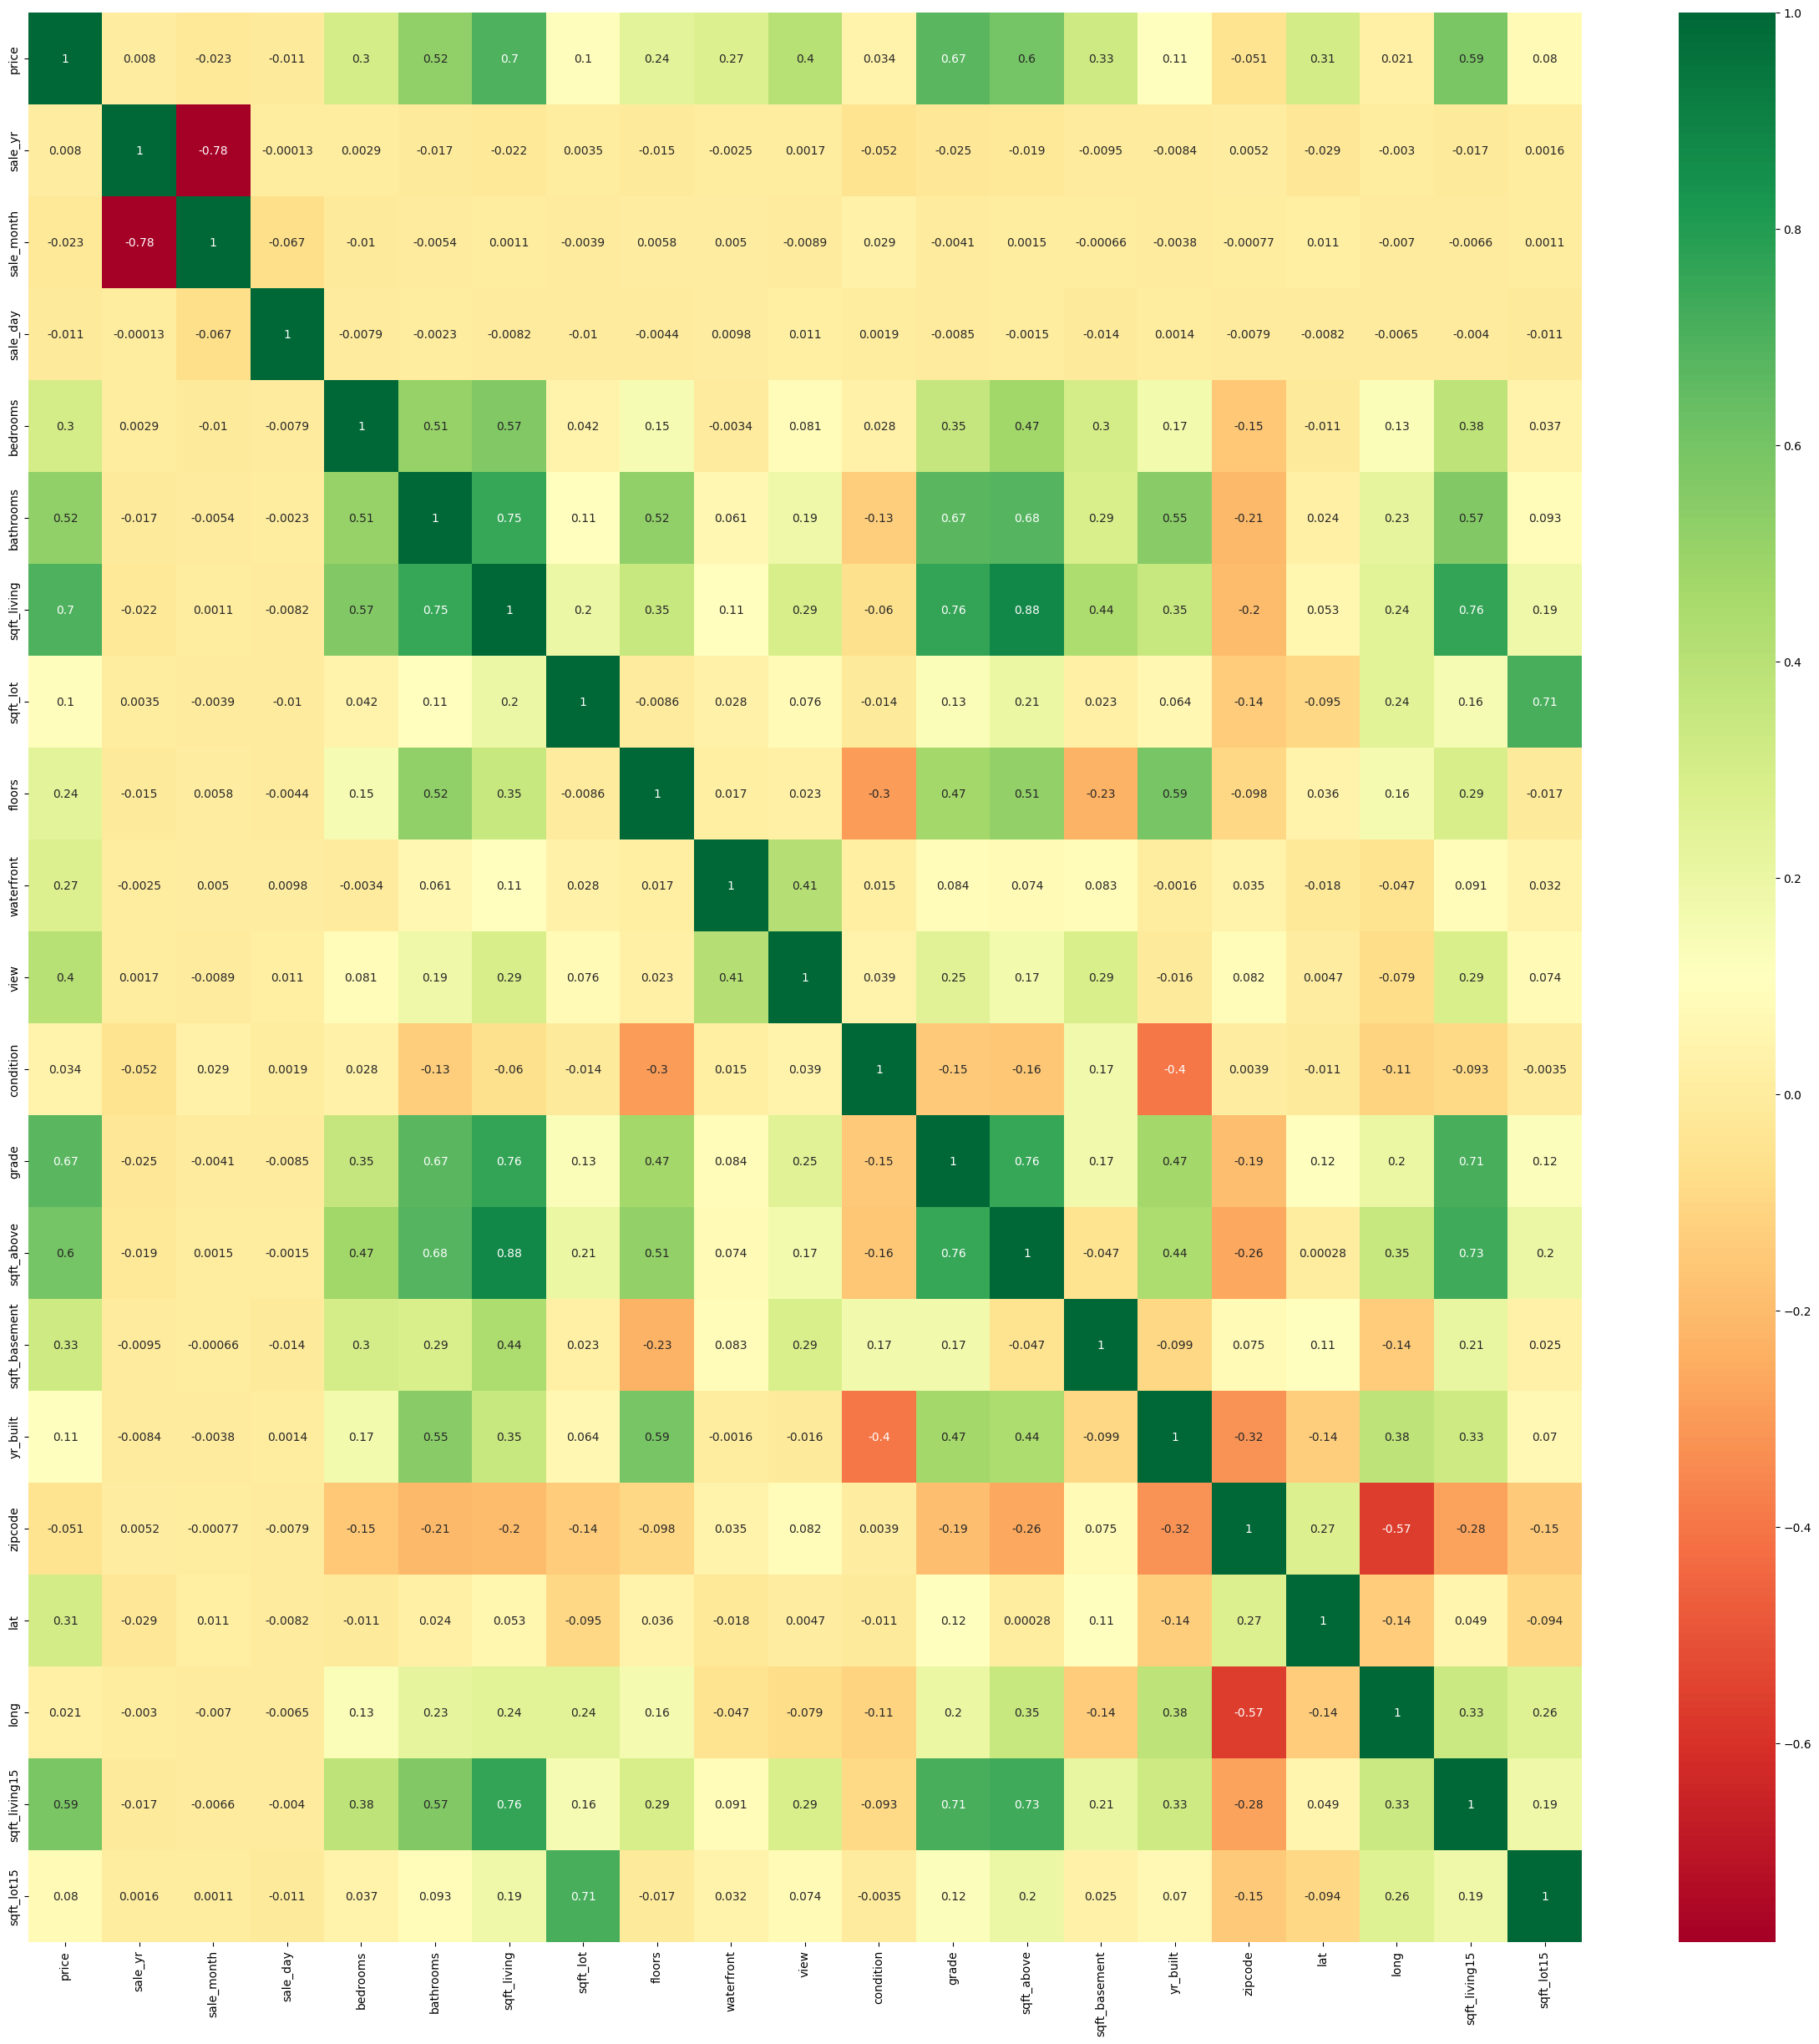

In [10]:
corr = train_data.corr()
highly_corr_features = corr.index[abs(corr["price"])>0]
plt.figure(figsize=(30,30))
map = sns.heatmap(train_data[highly_corr_features].corr(),annot=True,cmap="RdYlGn")

highly_corr_features = corr.index[(corr["price"])>0]

# Data Normalization
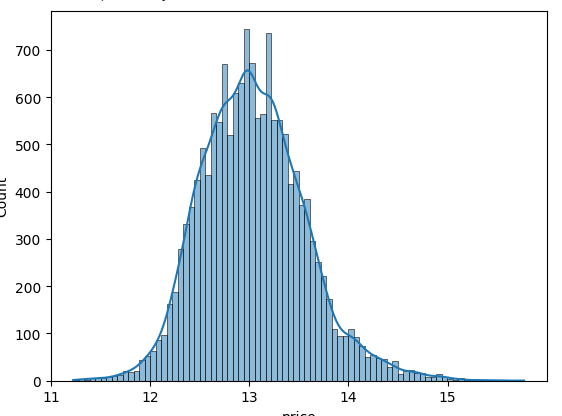

<Axes: xlabel='price', ylabel='Count'>

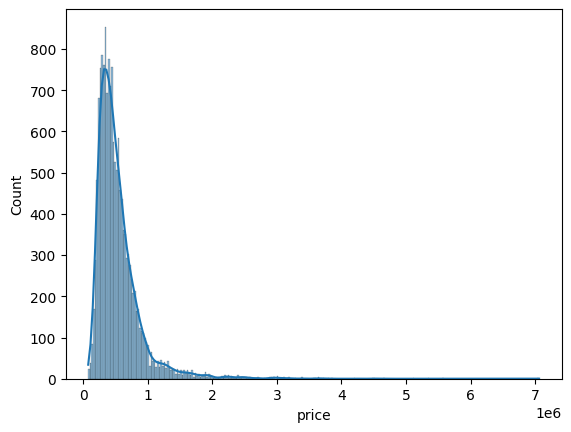

In [11]:
sns.histplot(target,kde=True)

<Axes: xlabel='price', ylabel='Count'>

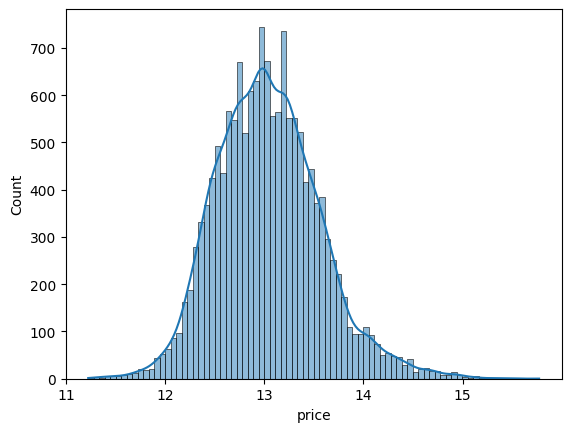

In [12]:
target = np.log1p(target) # log1p = log(x+1)
sns.histplot(target,kde=True)

# Q-Q 图
### 量化-量化图（Quantile-Quantile Plot）是一种可视化工具，用于比较数据的分位数与理论正态分布的分位数。如果数据点不在一条直线上，可能表明数据不符合正态分布。##

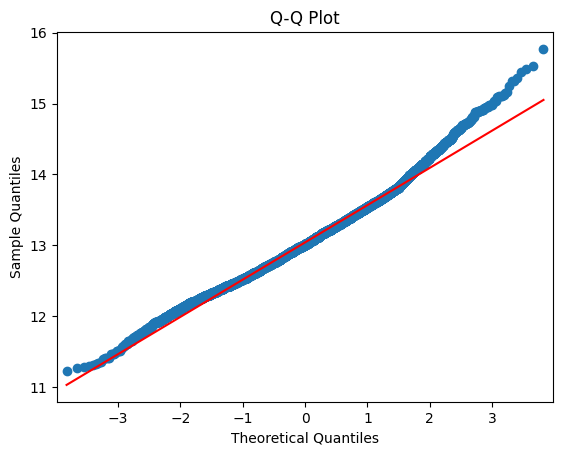

In [13]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.qqplot(target, line='s')  # line='s' 表示绘制一条参考线，该线表示理论正态分布的分位数

# 添加标题和标签
plt.title("Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# 显示 Q-Q 图
plt.show()

# Delete Data correlation "price"

In [14]:
highly_corr_features

Index(['price', 'sale_yr', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [15]:
# remove index price
highly_corr_features=highly_corr_features.delete(0).copy()

# 劃出 price 與correlation data 相關圖

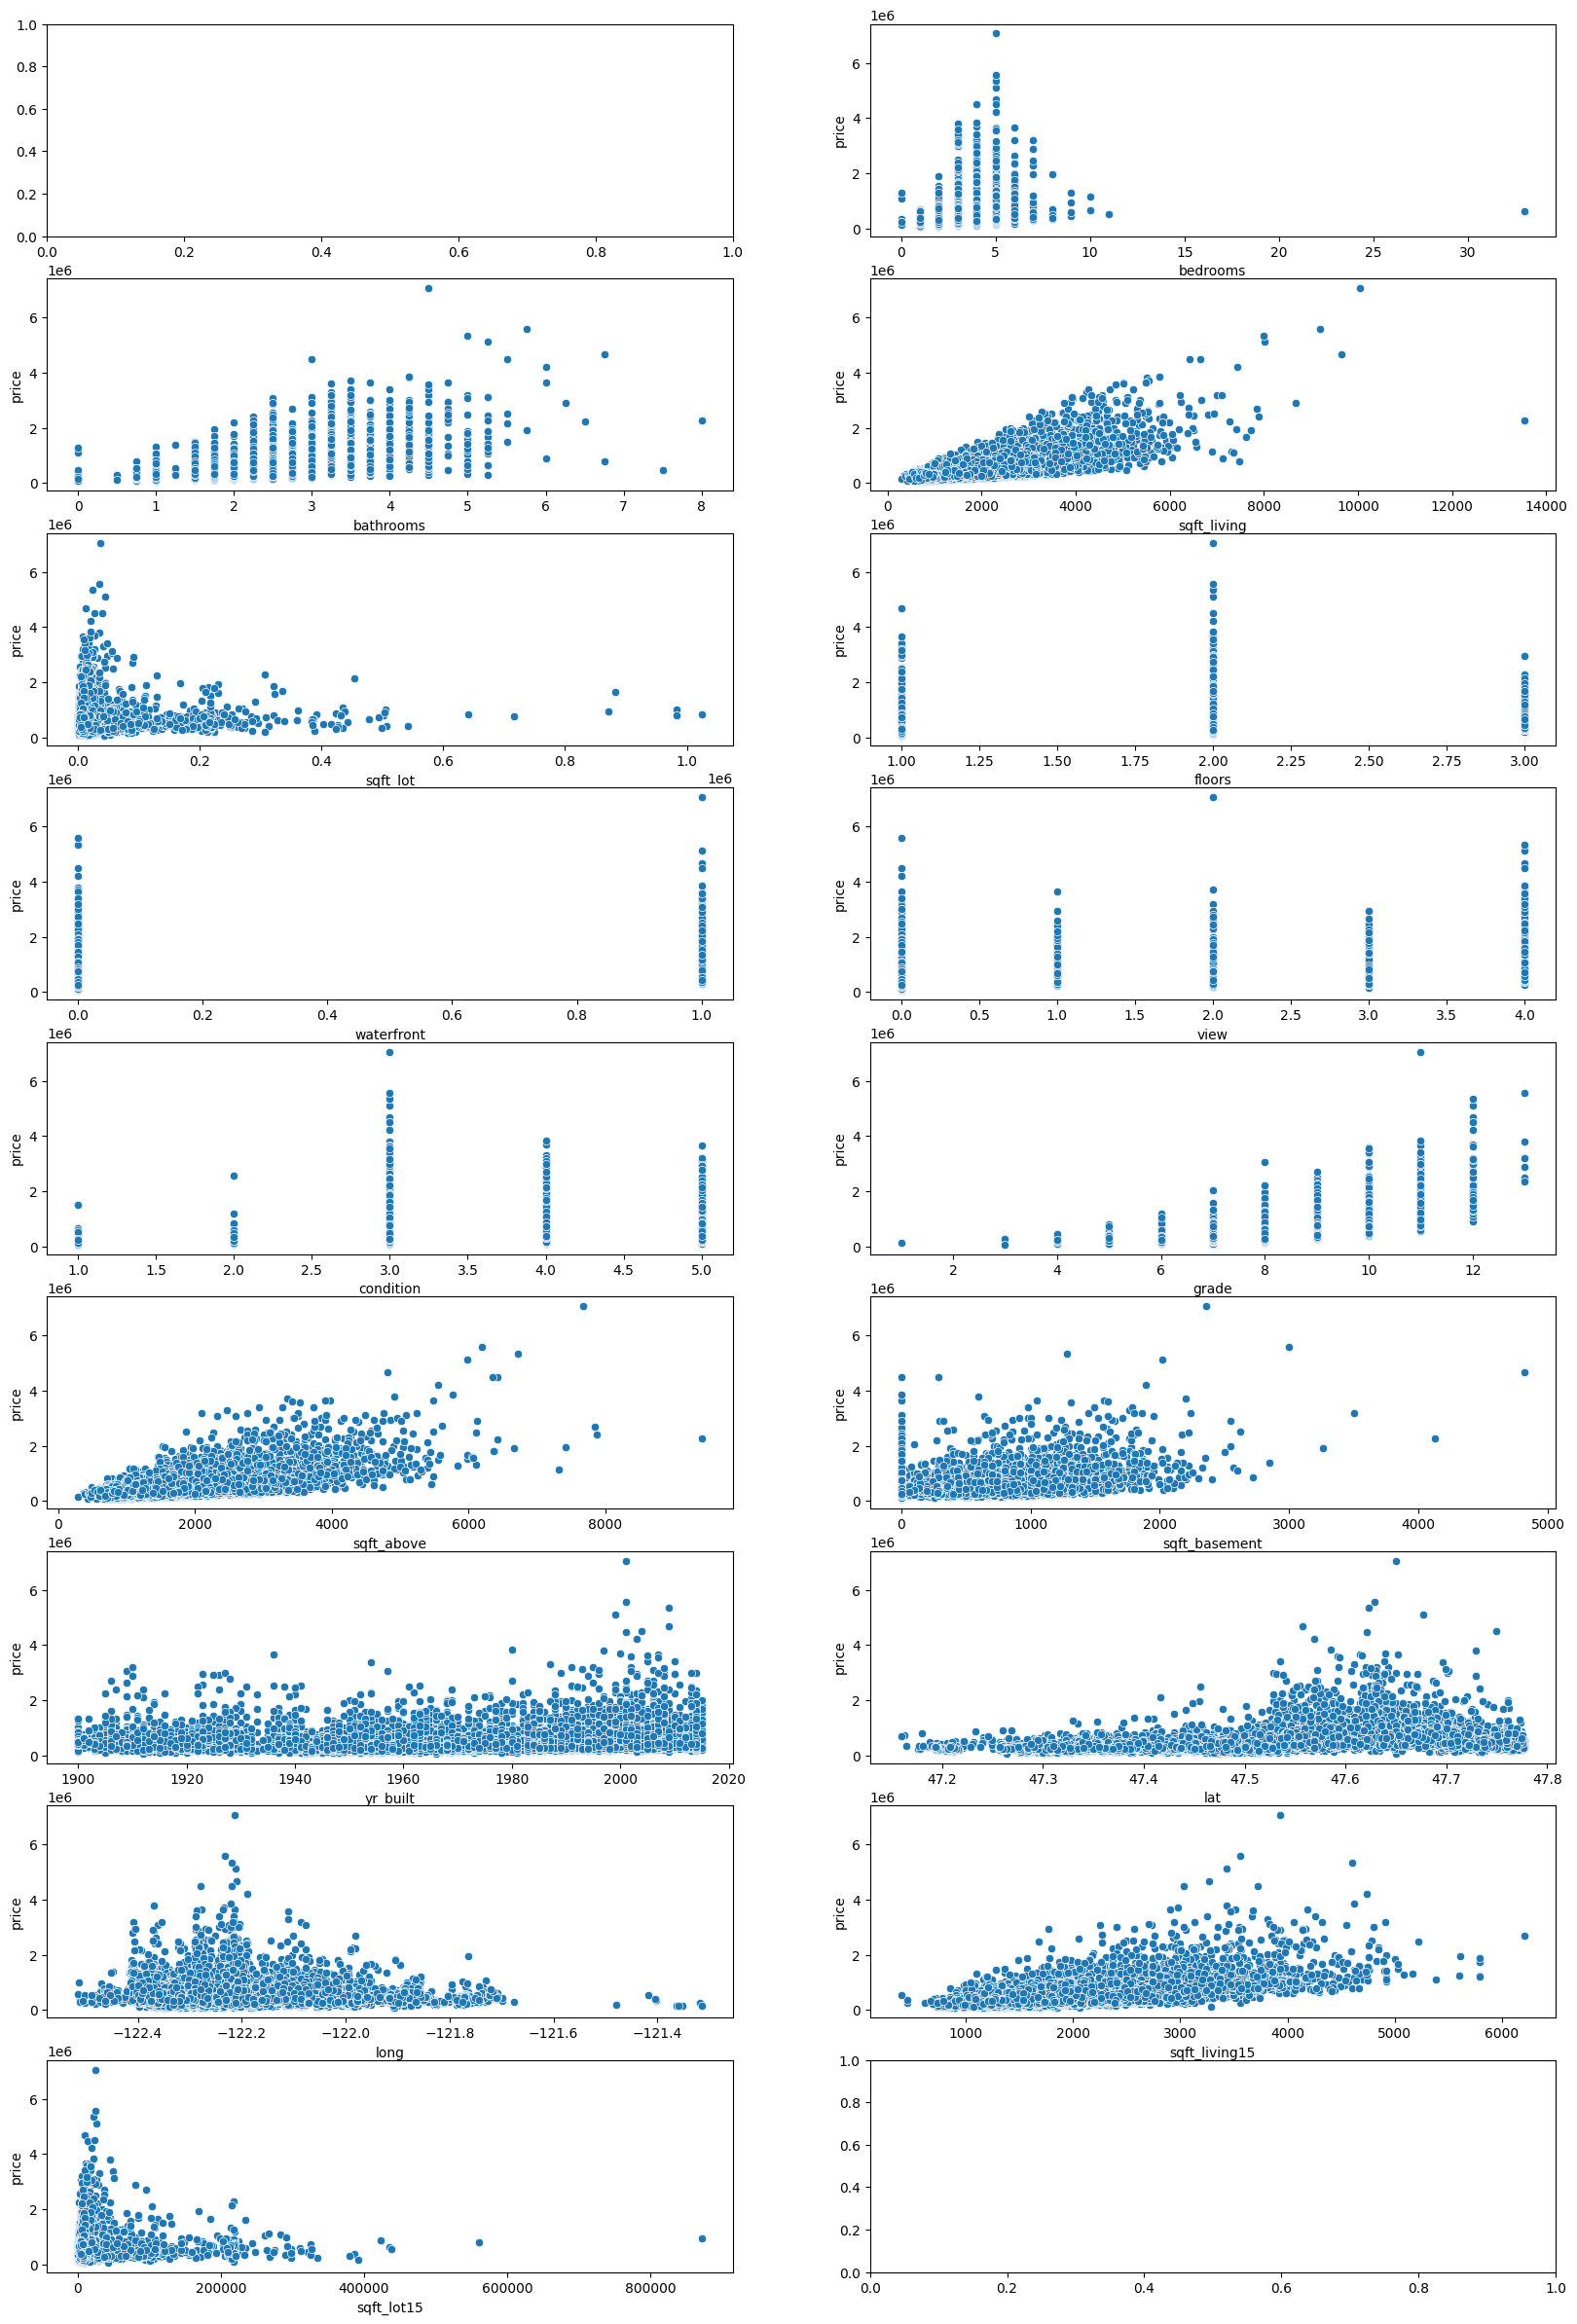

In [ ]:
length=len(highly_corr_features)
fig,ax = plt.subplots(length//2+1,2,figsize = (20, 30))

for i in range(1,length):
  # plt.subplot(i,2,i%2+1)
  sns.scatterplot(data=train_data, x=highly_corr_features[i], y="price",ax=ax[(i)//2,i%2])
plt.show()


# 把test data 和 train data合併，統一處理

In [16]:
data = pd.concat([train_data,test_data], axis=0,ignore_index=True)
y_train = target
data['long']=abs(data['long'])
data = data.drop(labels='price',axis=1)


In [ ]:
data.head()

,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,2015,3,27,4,2.0,1900,8160,1,0,0,3,7,1900,0,1975,98022,47.2114,121.986,1280,6532
1,2014,9,2,4,3.0,3380,16133,1,0,1,3,8,2330,1050,1959,98118,47.5501,122.261,2500,11100
2,2014,12,11,3,2.0,2070,9000,1,0,0,4,7,1450,620,1969,98023,47.3085,122.376,1630,7885
3,2015,4,30,3,1.0,1150,8924,1,0,0,3,6,1150,0,1943,98030,47.3865,122.217,1492,8924
4,2015,3,31,3,2.5,2040,7503,2,0,0,3,8,2040,0,1987,98029,47.5718,122.021,2170,7503


In [ ]:
data[data.select_dtypes(exclude='object').columns].describe()

,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,2014.322954,6.574423,15.688197,3.370842,2.114757,2079.899736,1.510697e+04,1.446213,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1972.648591,98077.939805,47.560053,122.213896,1986.552492,12768.455652
std,0.467616,3.115308,8.635063,0.930062,0.770163,918.440897,4.142051e+04,0.551894,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.009741,53.505026,0.138564,0.140828,685.391304,27304.179631
min,2014.000000,1.000000,1.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,98001.000000,47.155900,121.315000,399.000000,651.000000
25%,2014.000000,4.000000,8.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1953.000000,98033.000000,47.471000,122.125000,1490.000000,5100.000000
50%,2014.000000,6.000000,16.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1977.000000,98065.000000,47.571800,122.230000,1840.000000,7620.000000
75%,2015.000000,9.000000,23.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1998.000000,98118.000000,47.678000,122.328000,2360.000000,10083.000000
max,2015.000000,12.000000,31.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.000000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,47.777600,122.519000,6210.000000,871200.000000


In [17]:
#Top skewed columns
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0]
print(high_skew)

sqft_lot         13.059113
waterfront       11.384318
sqft_lot15        9.506083
view              3.395514
bedrooms          1.974163
sqft_basement     1.577856
sqft_living       1.471453
sqft_above        1.446564
sqft_living15     1.108104
condition         1.032733
grade             0.771050
sale_yr           0.757247
floors            0.726128
bathrooms         0.511072
zipcode           0.405633
sale_month        0.063126
sale_day         -0.005677
lat              -0.485237
yr_built         -0.528660
long             -0.884992
dtype: float64


# 使用 correlation 較高的資料

In [18]:
# Data Normalization
# method 1 - 使用所有特徵，並且做lop1p
for feature in data.columns:
  data[feature] = np.log1p(data[feature])
  if data[feature].isnull().sum()>0:
    print(f"Have Nan in {feature}")
    data=data.drop(labels=feature,axis=1)

# method 2 - 使用correlation 較大的值，並且做 StandardScaler
from sklearn.preprocessing import StandardScaler
# 创建 StandardScaler 对象
scaler = StandardScaler()
# 使用 StandardScaler 对数据进行标准化
normalized_data = scaler.fit_transform(train_data[highly_corr_features])
data.head()

,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,7.608871,1.386294,3.332205,1.609438,1.098612,7.550135,9.007122,0.693147,0.0,0.000000,1.386294,2.079442,7.550135,0.000000,7.588830,11.492957,3.875596,4.812071,7.155396,8.784622
1,7.608374,2.302585,1.098612,1.609438,1.386294,8.125927,9.688684,0.693147,0.0,0.693147,1.386294,2.197225,7.754053,6.957497,7.580700,11.493936,3.882596,4.814304,7.824446,9.314790
2,7.608374,2.564949,2.484907,1.386294,1.098612,7.635787,9.105091,0.693147,0.0,0.000000,1.609438,2.079442,7.280008,6.431331,7.585789,11.492968,3.877608,4.815237,7.396949,8.972844
3,7.608871,1.609438,3.433987,1.386294,0.693147,7.048386,9.096612,0.693147,0.0,0.000000,1.386294,1.945910,7.048386,0.000000,7.572503,11.493039,3.879221,4.813947,7.308543,9.096612
4,7.608871,1.386294,3.465736,1.386294,1.252763,7.621195,8.923191,1.098612,0.0,0.000000,1.386294,2.197225,7.621195,0.000000,7.594884,11.493029,3.883043,4.812355,7.682943,8.923191


In [ ]:
normalized_data.shape

(15128, 17)

# Save Data to excel

In [19]:
import csv
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'price'])
        for i, p in enumerate(preds):
            writer.writerow([i+1, p])


In [21]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


# Stacking Ensemble Machine Learning method:
#### 會用到不同種類的模型，每個模型看到的特徵不一樣，綜合所有模型取出最好的預測

##### 想要用什麼模型都行

In [22]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.classifier import StackingCVClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5)  # 使用5折交叉验证
idx=0
RANDOM_SEED = 42
base_regressor = DecisionTreeRegressor(max_depth=6)  # 基本回归器，默认为决策树回归器
catboost_regressor = CatBoostRegressor(loss_function='RMSE',  # 设置损失函数为均方误差
                    iterations=1000,       # 迭代次数
                    learning_rate=0.1,    # 学习率
                    depth=6,              # 树的深度
                    random_state=RANDOM_SEED)

lgb_regressor = lgb.LGBMRegressor(objective='mse',  # 设置损失函数为均方误差
                  n_estimators=1000,  # 迭代次数
                  learning_rate=0.1,  # 学习率
                  max_depth=4,        # 树的深度
                  random_state=RANDOM_SEED,
                  verbose=2)
gb_regressor = GradientBoostingRegressor(n_estimators=1000,  # 迭代次数
                      learning_rate=0.1,  # 学习率
                      max_depth=6,        # 树的深度
                      random_state=RANDOM_SEED,
                      loss="squared_error")
RF_regressor=RandomForestRegressor(n_estimators=1000,criterion="squared_error",random_state=RANDOM_SEED)
AdaB_regressor=AdaBoostRegressor(
            base_estimator=base_regressor,  # 基本回归器
            n_estimators=1000,               # 基本回归器的数量
            learning_rate=1.0,             # 学习率
            loss='square',                 # 损失函数，可以是 'linear', 'square', 'exponential'
            random_state=RANDOM_SEED                # 随机种子，用于重现性
)
model_xgb = XGBRegressor(n_estimators = 500,
                max_depth = 4,
                learning_rate = 0.1,
                objective = 'reg:squarederror',
                min_child_weight = 0,
                reg_lambda = 0,
                random_state=RANDOM_SEED)


# Data split with test and train

---



In [24]:
from sklearn.model_selection import train_test_split

train =data[:len(y_train)]
test = data[len(y_train):]
#Printing thier shapes
x_train,y_train=train,target

#Dividing data back into train & test
x_train, x_test, y_train, y_test = train_test_split(train, y_train, test_size=0.05, random_state=10)



In [25]:
print(f"x_train.shape {x_train.shape} | y_train.shape :{y_train.shape}")
print(f"x_test.shape {x_test.shape} | y_test.shape :{y_test.shape}")

x_train.shape (14371, 20) | y_train.shape :(14371,)
x_test.shape (757, 20) | y_test.shape :(757,)


# AdaBoostRegressor

In [ ]:
AdaB_regressor.fit(x_train,y_train)

# Train 使用训练好的模型进行预测
y_pred_train_AdaB = AdaB_regressor.predict(x_train)
# 评估模型性能（例如，使用均方误差）
train_mse_AdaB = mean_squared_error(y_pred_train_AdaB, y_train)
print(f"AdaB_regressor_Train MSE : {train_mse_AdaB}")

# Valid 使用训练好的模型进行预测
y_pred_valid_AdaB = AdaB_regressor.predict(x_test)
# 评估模型性能（例如，使用均方误差）
valid_mse_AdaB = mean_squared_error(y_pred_valid_AdaB,y_test)
print(f"AdaB_regressor_Valid MSE : {valid_mse_AdaB}")

# Test
pred1=AdaB_regressor.predict(test)
print(pred1)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaB_regressor_Train MSE : 0.030128182755663993
AdaB_regressor_Valid MSE : 0.036683621899792754
[13.3693553  13.46073962 13.01829943 ... 12.57539677 12.98073598
 12.07426624]


# RandomForestRegressor

In [ ]:
RF_regressor.fit(x_train,y_train)

# Train 使用训练好的模型进行预测
y_pred_train_RF = RF_regressor.predict(x_train)
# 评估模型性能（例如，使用均方误差）
train_mse_RF = mean_squared_error(y_pred_train_RF, y_train)
print(f"RandomForestRegressor_Train MSE : {train_mse_RF}")

# Valid使用训练好的模型进行预测
y_pred_valid_RF = RF_regressor.predict(x_test)
# y_pred = np.expm1(y_pred)
# 评估模型性能（例如，使用均方误差）
valid_mse_RF = mean_squared_error(y_pred_valid_RF,y_test)
print(f"RandomForestRegressor_Valid MSE : {valid_mse_RF}")

# Test
pred2=RF_regressor.predict(test)
print(pred2)

RandomForestRegressor_Train MSE : 0.004268791068914176
RandomForestRegressor_Valid MSE : 0.03305552530491726
[13.50731858 13.43178114 13.08486773 ... 12.65771497 12.86974566
 12.21395437]


# GradientBoostingRegressor

In [ ]:
gb_regressor.fit(x_train,y_train)

# Train 使用训练好的模型进行预测
y_pred_train_gb = gb_regressor.predict(x_train)
# 评估模型性能（例如，使用均方误差）
train_mse_gb = mean_squared_error(y_pred_train_gb, y_train)
print(f"GradientBoostingRegressor_Train MSE : {train_mse_gb}")

# Valid 使用训练好的模型进行预测
y_pred_valid_gb = gb_regressor.predict(x_test)
# 评估模型性能（例如，使用均方误差）
valid_mse_gb = mean_squared_error(y_pred_valid_gb,y_test)
print(f"GradientBoostingRegressor_Valid MSE : {valid_mse_gb}")

# Test
pred3=gb_regressor.predict(test)
print(pred3)

GradientBoostingRegressor_Train MSE : 0.0020029462675455307
GradientBoostingRegressor_Valid MSE : 0.026183408896831562
[13.57974274 13.51763707 13.09426312 ... 12.73242981 12.841755
 12.24040979]


# CatBoostRegressor

In [26]:
catboost_regressor.fit(x_train,y_train)

# Train 使用训练好的模型进行预测
y_pred_train_catboost = catboost_regressor.predict(x_train)
# 评估模型性能（例如，使用均方误差）
train_mse_catboost = mean_squared_error(y_pred_train_catboost, y_train)
print(f"CatBoostRegressor_Train MSE : {train_mse_catboost}")


# Valid 使用训练好的模型进行预测
y_pred_valid_catboost = catboost_regressor.predict(x_test)
# 评估模型性能（例如，使用均方误差）
valid_mse_catboost = mean_squared_error(y_pred_valid_catboost,y_test)
print(f"CatBoostRegressor_Valid MSE : {valid_mse_catboost}")

# Test
pred4=catboost_regressor.predict(test)
print(pred4)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4909281	test: 0.4997830	best: 0.4997830 (0)	total: 75.7ms	remaining: 1m 15s
1:	learn: 0.4586207	test: 0.4655089	best: 0.4655089 (1)	total: 97.9ms	remaining: 48.9s
2:	learn: 0.4306778	test: 0.4363239	best: 0.4363239 (2)	total: 120ms	remaining: 39.9s
3:	learn: 0.4058312	test: 0.4110275	best: 0.4110275 (3)	total: 144ms	remaining: 36s
4:	learn: 0.3836690	test: 0.3885941	best: 0.3885941 (4)	total: 163ms	remaining: 32.4s
5:	learn: 0.3641314	test: 0.3683896	best: 0.3683896 (5)	total: 191ms	remaining: 31.7s
6:	learn: 0.3463427	test: 0.3495466	best: 0.3495466 (6)	total: 211ms	remaining: 30s
7:	learn: 0.3308249	test: 0.3330527	best: 0.3330527 (7)	total: 229ms	remaining: 28.4s
8:	learn: 0.3161034	test: 0.3181369	best: 0.3181369 (8)	total: 248ms	remaining: 27.3s
9:	learn: 0.3030550	test: 0.3053256	best: 0.3053256 (9)	total: 274ms	remaining: 27.1s
10:	learn: 0.2925605	test: 0.2944845	best: 0.2944845 (10)	total: 310ms	remaining: 27.9s
11:	learn: 0.2812872	test: 0.2833599	best: 0.2833599 

# LGBMRegressor

In [ ]:
lgb_regressor.fit(x_train,y_train)

# Train 使用训练好的模型进行预测
y_pred_train_lgb = catboost_regressor.predict(x_train)
# 评估模型性能（例如，使用均方误差）
train_mse_lgb = mean_squared_error(y_pred_train_lgb, y_train)
print(f"LGBMRegressor_Train MSE : {train_mse_lgb}")

# Valid 使用训练好的模型进行预测
y_pred_valid_lgb = lgb_regressor.predict(x_test)
# y_pred = np.expm1(y_pred)
# 评估模型性能（例如，使用均方误差）
valid_mse_lgb = mean_squared_error(y_pred_valid_lgb,y_test)
print(f"LGBMRegressor_Valid MSE : {valid_mse_lgb}")

# Test
pred5=lgb_regressor.predict(test)
print(pred5)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.833739
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.125120
[LightGBM] [Debug] init for col-wise cost 0.001877 seconds, init for row-wise cost 0.002777 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14371, number of used features: 20
[LightGBM] [Info] Start training from score 13.039363
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a

# Method1 - Average
### 0.2 * model1 + 0.2 * model2 + 0.2 * model + ...

##### 可根據MSE大小去調整每個MODEL的權重
#####EX: AdaBoostRegressor的MSE較大，權重可以較小

##### **Best performance**
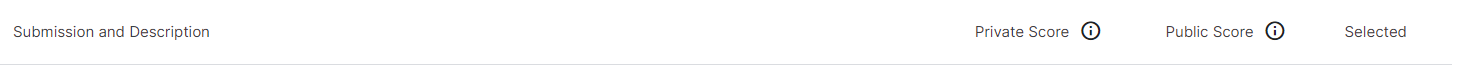
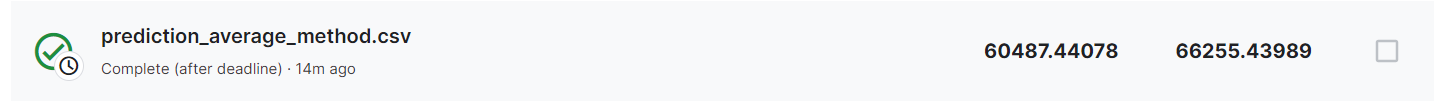

In [ ]:
pred=pred1*0.1+pred2*0.2+pred3*0.23+pred4*0.23+pred5*0.24
pred=np.expm1(pred)
print(pred)
save_pred(pred,'prediction_average_method.csv')

[743955.62039374 713104.75650391 479558.15512667 ... 321011.93798397
 389376.34033205 202959.99800362]


# Method2 - XGBRegressor
##### **對n種model 預測出來的價格(y_pred_train)在做訓練**
##### ***不一定要用 XGBRegressor ，也可自行用其他model做(SVM、KNN、NN、自己訓練也可)***

In [ ]:
# train data process
y_pred_AdaB=y_pred_train_AdaB[:,np.newaxis] # append new dim
y_pred_RF=y_pred_train_RF[:,np.newaxis]
y_pred_gb=y_pred_train_gb[:,np.newaxis]
y_pred_catboost=y_pred_train_catboost[:,np.newaxis]
y_pred_lgb=y_pred_train_lgb[:,np.newaxis]


In [ ]:
print(f"y_pred_AdaB.shape : {y_pred_AdaB.shape} | y_pred_RF.shape : {y_pred_RF.shape} | y_pred_gb.shape : {y_pred_gb.shape} | y_pred_catboost.shape : {y_pred_catboost.shape} | y_pred_lgb.shape : {y_pred_lgb.shape}")
pred_train=np.concatenate( (y_pred_AdaB,y_pred_RF,y_pred_gb,y_pred_catboost,y_pred_lgb), axis=1)
print(f"xgb_train.shape : {pred_train.shape} | y_train.shape : {y_train.shape}")

y_pred_AdaB.shape : (14371, 1) | y_pred_RF.shape : (14371, 1) | y_pred_gb.shape : (14371, 1) | y_pred_catboost.shape : (14371, 1) | y_pred_lgb.shape : (14371, 1)
xgb_train.shape : (14371, 5) | y_train.shape : (14371,)


In [ ]:
# valid data process
y_pred_xgb_AdaB=y_pred_valid_AdaB[:,np.newaxis] # append new dim
y_pred_xgb_RF=y_pred_valid_RF[:,np.newaxis]
y_pred_xgb_gb=y_pred_valid_gb[:,np.newaxis]
y_pred_xgb_catboost=y_pred_valid_catboost[:,np.newaxis]
y_pred_xgb_lgb=y_pred_valid_lgb[:,np.newaxis]

In [ ]:
print(f"y_pred_xgb_AdaB.shape : {y_pred_xgb_AdaB.shape} | y_pred_xgb_RF.shape : {y_pred_xgb_RF.shape} | y_pred_xgb_gb.shape : {y_pred_xgb_gb.shape} | y_pred_xgb_catboost.shape : {y_pred_xgb_catboost.shape} | y_pred_xgb_lgb.shape : {y_pred_xgb_lgb.shape}")
pred_valid=np.concatenate( (y_pred_xgb_AdaB,y_pred_xgb_RF,y_pred_xgb_gb,y_pred_xgb_catboost,y_pred_xgb_lgb), axis=1)
print(f"xgb_valid.shape : {pred_valid.shape} | y_test.shape : {y_test.shape}")

y_pred_xgb_AdaB.shape : (757, 1) | y_pred_xgb_RF.shape : (757, 1) | y_pred_xgb_gb.shape : (757, 1) | y_pred_xgb_catboost.shape : (757, 1) | y_pred_xgb_lgb.shape : (757, 1)
xgb_valid.shape : (757, 5) | y_test.shape : (757,)


In [ ]:
pred11=pred1[:,np.newaxis] # append new dim
pred21=pred2[:,np.newaxis]
pred31=pred3[:,np.newaxis]
pred41=pred4[:,np.newaxis]
pred51=pred5[:,np.newaxis]
print(f"pred11.shape : {pred11.shape} | pred21.shape : {pred21.shape} | pred31.shape : {pred31.shape} | pred41.shape : {pred41.shape} | pred51.shape : {pred51.shape}")
pred_test=np.concatenate((pred11,pred21,pred31,pred41,pred51),axis=1)
print(f"preds.shape : {pred_test.shape}")

pred11.shape : (6485, 1) | pred21.shape : (6485, 1) | pred31.shape : (6485, 1) | pred41.shape : (6485, 1) | pred51.shape : (6485, 1)
preds.shape : (6485, 5)


In [ ]:
model_xgb.fit(pred_train,y_train)

# Train 使用训练好的模型进行预测
y_pred_train_xgb = model_xgb.predict(pred_train)
# 评估模型性能（例如，使用均方误差）
train_mse_xgb = mean_squared_error(y_pred_train_xgb,y_train)
print(f"XGBRegressor_Train MSE : {train_mse_xgb}")

# Valid 使用训练好的模型进行预测
y_pred_valid_xgb = model_xgb.predict(pred_valid)
# 评估模型性能（例如，使用均方误差）
valid_mse_xgb = mean_squared_error(y_pred_valid_xgb,y_test)
print(f"XGBRegressor_Valid MSE : {valid_mse_xgb}")

# Test
prediction=model_xgb.predict(pred_test)
prediction=np.expm1(prediction)
save_pred(prediction,'prediction_xgb_method.csv')

XGBRegressor_Train MSE : 0.0005590537426185968
XGBRegressor_Valid MSE : 0.02889145986984016


## 畫出 Loss Decay

In [27]:
max_idx=2000
train_loss_AdaB=[]
valid_loss_AdaB=[]
train_loss_RF=[]
valid_loss_RF=[]
train_loss_gb=[]
valid_loss_gb=[]
train_loss_catboost=[]
valid_loss_catboost=[]
train_loss_lgb=[]
valid_loss_lgb=[]
train_loss_xgb=[]
valid_loss_xgb=[]
valid_loss=1
for i in range(1,max_idx):
  #####################################################################################################
  catboost_regressor = CatBoostRegressor(loss_function='RMSE',  # 设置损失函数为均方误差
                    iterations=i,       # 迭代次数
                    learning_rate=0.1,    # 学习率
                    depth=6,              # 树的深度
                    random_state=RANDOM_SEED)

  lgb_regressor = lgb.LGBMRegressor(objective='mse',  # 设置损失函数为均方误差
                    n_estimators=i,  # 迭代次数
                    learning_rate=0.1,  # 学习率
                    max_depth=4,        # 树的深度
                    random_state=RANDOM_SEED,)

  gb_regressor = GradientBoostingRegressor(n_estimators=i,  # 迭代次数
                        learning_rate=0.1,  # 学习率
                        max_depth=6,        # 树的深度
                        random_state=RANDOM_SEED,
                        loss="squared_error")

  RF_regressor=RandomForestRegressor(n_estimators=i,criterion="squared_error",random_state=RANDOM_SEED)

  AdaB_regressor=AdaBoostRegressor(
              base_estimator=base_regressor,  # 基本回归器
              n_estimators=i,               # 基本回归器的数量
              learning_rate=1.0,             # 学习率
              loss='square',                 # 损失函数，可以是 'linear', 'square', 'exponential'
              random_state=RANDOM_SEED                # 随机种子，用于重现性
              )

  model_xgb = XGBRegressor(n_estimators = i,
                  max_depth = 4,
                  learning_rate = 0.1,
                  objective = 'reg:squarederror',
                  min_child_weight = 0,
                  reg_lambda = 0,
                  random_state=RANDOM_SEED)
  #####################################################################################################
  AdaB_regressor.fit(x_train,y_train)

  # Train 使用训练好的模型进行预测
  y_pred_train_AdaB = AdaB_regressor.predict(x_train)
  # 评估模型性能（例如，使用均方误差）
  train_mse_AdaB = mean_squared_error(y_pred_train_AdaB, y_train)
  print(f"AdaB_regressor_Train MSE : {train_mse_AdaB}")
  train_loss_AdaB.append(train_mse_AdaB)
  # Valid 使用训练好的模型进行预测
  y_pred_valid_AdaB = AdaB_regressor.predict(x_test)
  # 评估模型性能（例如，使用均方误差）
  valid_mse_AdaB = mean_squared_error(y_pred_valid_AdaB,y_test)
  print(f"AdaB_regressor_Valid MSE : {valid_mse_AdaB}")
  valid_loss_AdaB.append(valid_mse_AdaB)
  # Test
  pred1=AdaB_regressor.predict(test)
  #####################################################################################################
  RF_regressor.fit(x_train,y_train)

  # Train 使用训练好的模型进行预测
  y_pred_train_RF = RF_regressor.predict(x_train)
  # 评估模型性能（例如，使用均方误差）
  train_mse_RF = mean_squared_error(y_pred_train_RF, y_train)
  print(f"RandomForestRegressor_Train MSE : {train_mse_RF}")
  train_loss_RF.append(train_mse_RF)
  # Valid使用训练好的模型进行预测
  y_pred_valid_RF = RF_regressor.predict(x_test)
  # y_pred = np.expm1(y_pred)
  # 评估模型性能（例如，使用均方误差）
  valid_mse_RF = mean_squared_error(y_pred_valid_RF,y_test)
  print(f"RandomForestRegressor_Valid MSE : {valid_mse_RF}")
  valid_loss_RF.append(valid_mse_RF)
  # Test
  pred2=RF_regressor.predict(test)
  #####################################################################################################
  gb_regressor.fit(x_train,y_train)

  # Train 使用训练好的模型进行预测
  y_pred_train_gb = gb_regressor.predict(x_train)
  # 评估模型性能（例如，使用均方误差）
  train_mse_gb = mean_squared_error(y_pred_train_gb, y_train)
  print(f"GradientBoostingRegressor_Train MSE : {train_mse_gb}")
  train_loss_gb.append(train_mse_gb)
  # Valid 使用训练好的模型进行预测
  y_pred_valid_gb = gb_regressor.predict(x_test)
  # 评估模型性能（例如，使用均方误差）
  valid_mse_gb = mean_squared_error(y_pred_valid_gb,y_test)
  print(f"GradientBoostingRegressor_Valid MSE : {valid_mse_gb}")
  valid_loss_gb.append(valid_mse_gb)
  # Test
  pred3=gb_regressor.predict(test)
  #####################################################################################################
  catboost_regressor.fit(x_train,y_train)

  # Train 使用训练好的模型进行预测
  y_pred_train_catboost = catboost_regressor.predict(x_train)
  # 评估模型性能（例如，使用均方误差）
  train_mse_catboost = mean_squared_error(y_pred_train_catboost, y_train)
  print(f"CatBoostRegressor_Train MSE : {train_mse_catboost}")
  train_loss_catboost.append(train_mse_catboost)

  # Valid 使用训练好的模型进行预测
  y_pred_valid_catboost = catboost_regressor.predict(x_test)
  # 评估模型性能（例如，使用均方误差）
  valid_mse_catboost = mean_squared_error(y_pred_valid_catboost,y_test)
  print(f"CatBoostRegressor_Valid MSE : {valid_mse_catboost}")
  valid_loss_catboost.append(valid_mse_catboost)
  # Test
  pred4=catboost_regressor.predict(test)
  #####################################################################################################
  lgb_regressor.fit(x_train,y_train)

  # Train 使用训练好的模型进行预测
  y_pred_train_lgb = catboost_regressor.predict(x_train)
  # 评估模型性能（例如，使用均方误差）
  train_mse_lgb = mean_squared_error(y_pred_train_lgb, y_train)
  print(f"LGBMRegressor_Train MSE : {train_mse_lgb}")
  train_loss_lgb.append(train_mse_lgb)

  # Valid 使用训练好的模型进行预测
  y_pred_valid_lgb = lgb_regressor.predict(x_test)
  # y_pred = np.expm1(y_pred)
  # 评估模型性能（例如，使用均方误差）
  valid_mse_lgb = mean_squared_error(y_pred_valid_lgb,y_test)
  print(f"LGBMRegressor_Valid MSE : {valid_mse_lgb}")
  valid_loss_lgb.append(valid_mse_lgb)
  # Test
  pred5=lgb_regressor.predict(test)
  #####################################################################################################
  # train data process
  y_pred_AdaB=y_pred_train_AdaB[:,np.newaxis] # append new dim
  y_pred_RF=y_pred_train_RF[:,np.newaxis]
  y_pred_gb=y_pred_train_gb[:,np.newaxis]
  y_pred_catboost=y_pred_train_catboost[:,np.newaxis]
  y_pred_lgb=y_pred_train_lgb[:,np.newaxis]
  pred_train=np.concatenate( (y_pred_AdaB,y_pred_RF,y_pred_gb,y_pred_catboost,y_pred_lgb), axis=1)
  # valid data process
  y_pred_xgb_AdaB=y_pred_valid_AdaB[:,np.newaxis] # append new dim
  y_pred_xgb_RF=y_pred_valid_RF[:,np.newaxis]
  y_pred_xgb_gb=y_pred_valid_gb[:,np.newaxis]
  y_pred_xgb_catboost=y_pred_valid_catboost[:,np.newaxis]
  y_pred_xgb_lgb=y_pred_valid_lgb[:,np.newaxis]
  pred_valid=np.concatenate( (y_pred_xgb_AdaB,y_pred_xgb_RF,y_pred_xgb_gb,y_pred_xgb_catboost,y_pred_xgb_lgb), axis=1)
  # Test data process
  pred11=pred1[:,np.newaxis] # append new dim
  pred21=pred2[:,np.newaxis]
  pred31=pred3[:,np.newaxis]
  pred41=pred4[:,np.newaxis]
  pred51=pred5[:,np.newaxis]
  # print(f"pred11.shape : {pred11.shape} | pred21.shape : {pred21.shape} | pred31.shape : {pred31.shape} | pred41.shape : {pred41.shape} | pred51.shape : {pred51.shape}")
  pred_test=np.concatenate((pred11,pred21,pred31,pred41,pred51),axis=1)
  # print(f"preds.shape : {pred_test.shape}")
  #####################################################################################################
  model_xgb.fit(pred_train,y_train)

  # Train 使用训练好的模型进行预测
  y_pred_train_xgb = model_xgb.predict(pred_train)
  # 评估模型性能（例如，使用均方误差）
  train_mse_xgb = mean_squared_error(y_pred_train_xgb,y_train)
  print(f"XGBRegressor_Train MSE : {train_mse_xgb}")
  train_loss_xgb.append(train_mse_xgb)
  # Valid 使用训练好的模型进行预测
  y_pred_valid_xgb = model_xgb.predict(pred_valid)
  # 评估模型性能（例如，使用均方误差）
  valid_mse_xgb = mean_squared_error(y_pred_valid_xgb,y_test)
  print(f"XGBRegressor_Valid MSE : {valid_mse_xgb}")
  valid_loss_xgb.append(valid_mse_xgb)
  # Test
  if valid_loss > valid_mse_xgb:
    valid_loss=valid_mse_xgb
    prediction=model_xgb.predict(pred_test)
    prediction=np.expm1(prediction)
    save_pred(prediction,'prediction_xgb_method.csv')
  #####################################################################################################

Output hidden; open in https://colab.research.google.com to view.

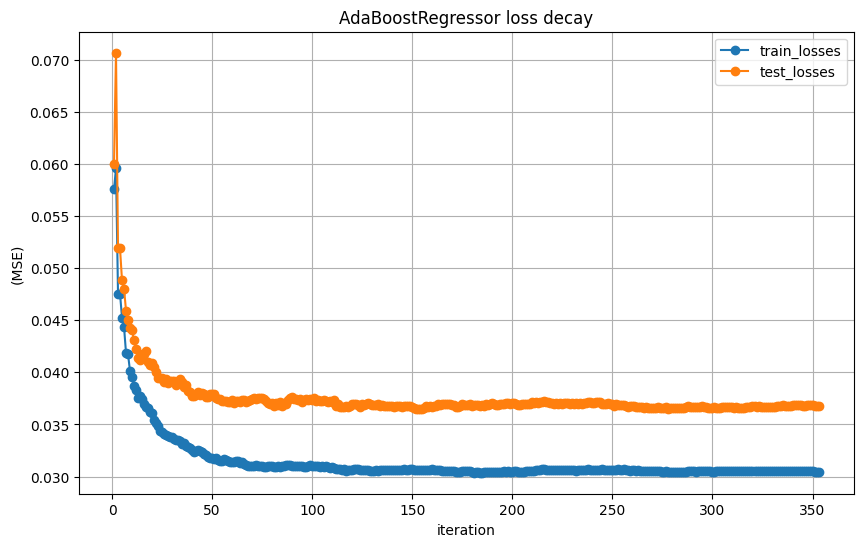

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_AdaB) + 1), train_loss_AdaB, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_loss_AdaB) + 1), valid_loss_AdaB, label='Valid Loss', marker='o')
plt.xlabel('iteration')
plt.ylabel('(MSE)')
plt.title('AdaBoostRegressor loss decay')
plt.legend(['train_losses','test_losses'])
plt.grid(True)
plt.show()

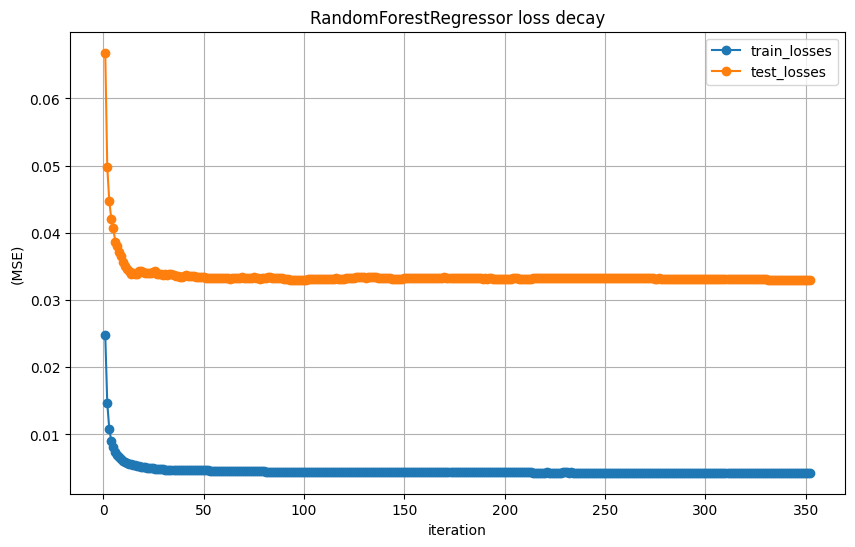

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_RF) + 1), train_loss_RF, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_loss_RF) + 1), valid_loss_RF, label='Valid Loss', marker='o')
plt.xlabel('iteration')
plt.ylabel('(MSE)')
plt.title('RandomForestRegressor loss decay')
plt.legend(['train_losses','test_losses'])
plt.grid(True)
plt.show()

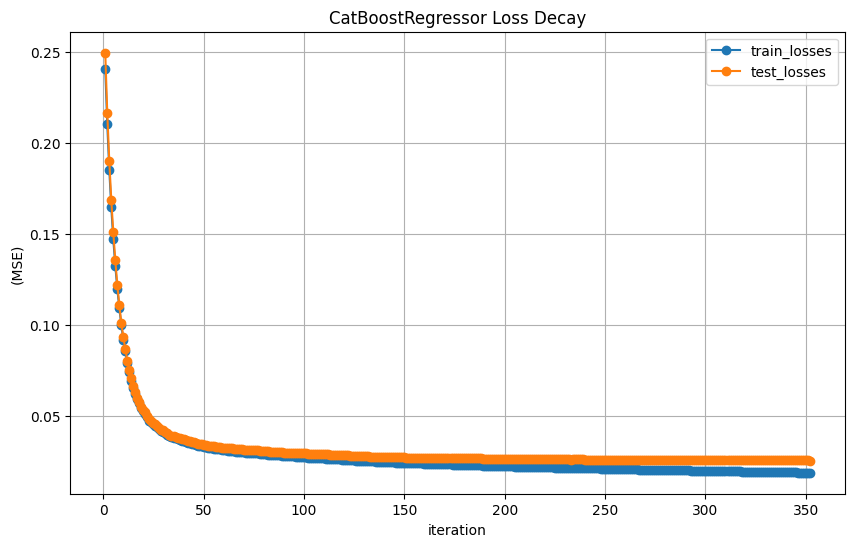

In [31]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_catboost) + 1), train_loss_catboost, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_loss_catboost) + 1), valid_loss_catboost, label='Valid Loss', marker='o')
plt.xlabel('iteration')
plt.ylabel('(MSE)')
plt.title('CatBoostRegressor Loss Decay')
plt.legend(['train_losses','test_losses'])
plt.grid(True)
plt.show()

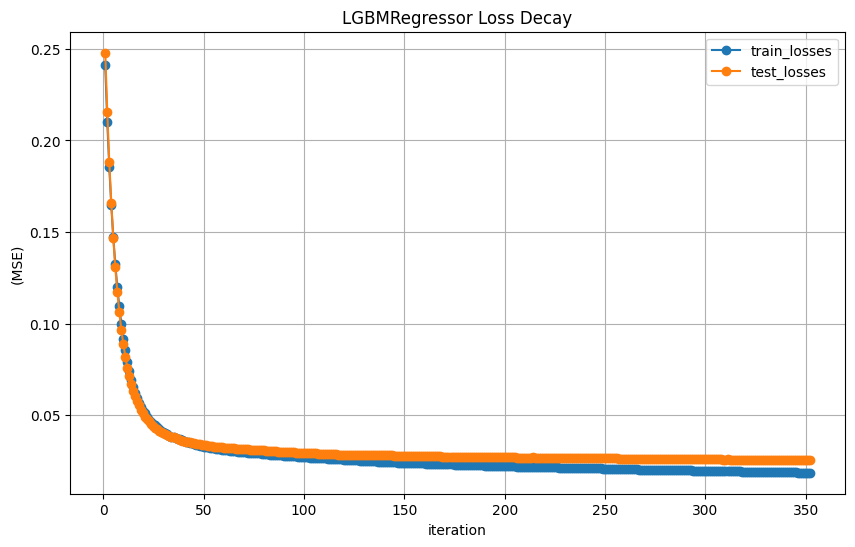

In [32]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_lgb) + 1), train_loss_lgb, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_loss_lgb) + 1), valid_loss_lgb, label='Valid Loss', marker='o')
plt.xlabel('iteration')
plt.ylabel('(MSE)')
plt.title('LGBMRegressor Loss Decay')
plt.legend(['train_losses','test_losses'])
plt.grid(True)
plt.show()

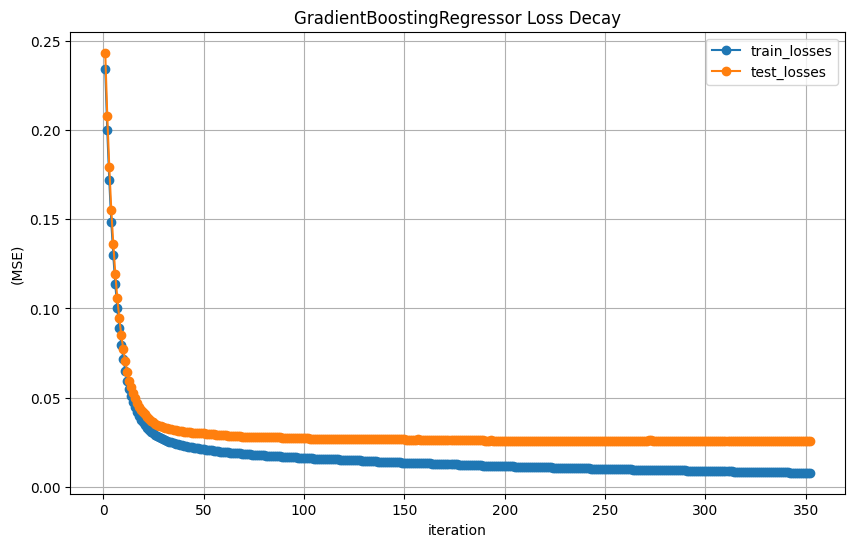

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_gb) + 1), train_loss_gb, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_loss_gb) + 1), valid_loss_gb, label='Valid Loss', marker='o')
plt.xlabel('iteration')
plt.ylabel('(MSE)')
plt.title('GradientBoostingRegressor Loss Decay')
plt.legend(['train_losses','test_losses'])
plt.grid(True)
plt.show()

# Method 3 - k cross validation
### Cross Validation detail:https://www.analyticsvidhya.com/blog/2021/11/top-7-cross-validation-techniques-with-python-code/
### https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
#### https://tomohiroliu22.medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98%E7%B3%BB%E5%88%97-44-%E5%A0%86%E7%96%8A%E5%88%86%E9%A1%9E-stacking-classifier-31c6427fd14c
#####將訓練資料進行分組，一部分做為訓練子集來訓練模型，另一部分做為驗證子集來評估模型。用訓練子集的數據先訓練模型，然後用驗證子集去跑一遍，看驗證集的損失函數(loss)或是分類準確率等。

**優點:**


1.   降低模型訓練對於資料集的偏差。
2.   訓練集與驗證集完整被充分利用與學習。


